# Comparing Matrix Factorization Models for Implicit Feedback

###[Will Kirwin](https://github.com/wkirwin)
October 25, 2015

**TL;DR** We compare various implicit factorization models for recommender systems on the Taste Profile dataset. It turns out that the supposed advantage of [Logistic Matrix Factorization Models](http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf) can be almost entirely attributed to the inclusion of user and item biases, and when the standard [implicit matrix factorization model](http://yifanhu.net/PUB/cf.pdf) of Hu, et al., is modified to include user and item biases, it outperforms Logistic MF.

## Introduction

In our last post, we discussed matrix factorization models for recommendation engines. In particular, we explained the *Alternating Least Squares* algorithm for computing latent factor models using implicit feedback. 

The basic model comes from [Hu, et al. Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf), and we showed how one can modify that algorithm to account for user and item biases (although when the data is implicit feedback, like clicks or song listens, and not direct ratings data, the *user bias*  should be interpreted as breadth of a users taste and *item bias* should be interpreted as broadness of appeal). 

In this post, we will compare the biased implicit feedback latent-factor model to another biased implicit model, called (somewhat incorrectly) *logistic matrix factorization*, which appeared in [C. Johnson, Logistic Matrix Factorization for Implicit Feedback Data](http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf).

We will refer to an implicit matrix factorization model as an IMF, and a logistic matrix factorization model as a LogMF.

***Remarks*** 

1. The name "Logistic Matrix Factorization" is a bit misleading. One downside to the interpretability of IMF models is that although the model is trying to predict a user's preference for an item, which should be a number between 0 and 1 (simply because of the way we define "preference"), the output of an IMF model is just a real number which can be, and often is, (slightly) outside of the interval [0, 1]. There are indeed implicit matrix factorization models which essentially pass the output of the model through a logistic function to ensure that the output is between 0 and 1. That is *not* what Johnson calls a Logistic Matrix Factorization Model. His model has different mathematical underpinnings (see equation (2) of the paper for the exact difference), but does involve both matrix factorization--with biases--as well as the logistic function.

2. In Johnson's paper, he compares LogMF to the IMF model of Hu, et al, which does not account for biases. As the LogMF model does account for biases, the comparison is a little bit apples to oranges. Part of the motivation for the current post is to compare *biased* IMF to LogMF. Johnson uses proprietary Spotify data to compare his model to the IMF model of Hu, et al, so is not directly reproducible, and finds that his model gives superior results. After reading his paper, we wondered if the difference could be explained by the inclusion of biases, rather than the slightly different underlying statistical model.

### The Data: Taste Profile

As we do not have access (and presumably, neither do you) to Spotify's proprietary internal listener data, we turned to publicly available datasets. We are aware of only a precious few implicit feedback datasets: the [Taste Profile](http://labrosa.ee.columbia.edu/millionsong/tasteprofile) data set, which contains (among other things) a large set of `(user, song, song_listened_count)` triplets (about 48 million of them). Another implicit feedback dataset is the [Last.fm Dataset - 1K users], which consists of `(timestamp, user, song)` triplets. 

Since we are interested in aggregate song-play counts, we will use the Taste Profile dataset. There were apparently some problems with the ETL and we need to throw out entries for "untrusted" songs (see the Taste Profile description for details).

After removing the bad triplets, we converted the user and song id's to integers, and saved the results in a `csv` file. The script for accomplishing all this is [here](https://github.com/wkirwin).

In [1]:
from __future__ import division, print_function
import sys, time

import numpy as np
import pandas as pd
import random

np.random.seed(42)
random.seed(42)

try:
    import cPickle as pkl
except Exception as e:
    import pickle as pkl
import gzip

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from model import ImplicitMF
sys.path.append('./logisticmf/')
import logisticmf
import recommendation_metrics as rm

## Data Preparation

Our IMF and LogMF models both take user-item matrices (that is, an `(num_users, num_songs)` matrix whose entries are the song play counts), so we need to load the Taste Profile data into matrix form. We also need to make a train/test split; we've chosen an 80/20 split. We could also do cross-validation, but we don't want to make things too complicated all at once. 

In this post, we will just use the first 2 million samples of the Taste Profile data set (so that our models can all be trained in a reasonable amount of time and we can all get back to work; if this were an official publication, we would use all the data). We have also decided to look only at the top 1000 songs. (Again, more for convenience than anything else).

The results are:

In [3]:
datafile = 'data/TasteProfile/clean_int_data.csv'

nrows = 2000000
data = pd.read_table(datafile,
                     sep=',',
                    header=None,
                    nrows = nrows)
data.columns = ['uid', 'mid', 'count']

n_triples = len(data) # total number of uid-mid-count triples

train_portion = 0.8 # how much of the data to use for training
cutoff = int(n_triples * train_portion)

train_rows = random.sample(range(n_triples), cutoff)
traindf = data.iloc[train_rows]
testdf = data.drop(train_rows)

# let's restrict to the top N most popular songs
n_pop = 1000

sgps = data.groupby('mid')
total_counts = sgps.sum()['count'].copy()
total_counts.sort(ascending=False)
pop_songs = total_counts.head(n_pop).copy()

pop_mids = set(pop_songs.index)

traindf = traindf[traindf.mid.isin(pop_mids)]
testdf = testdf[testdf.mid.isin(pop_mids)]

# remove uid/mid from testdf which do not appear in traindf 
train_uids = set(traindf.uid.unique())
train_mids = set(traindf.mid.unique())

ukeep_rows = testdf.uid.isin(train_uids)
testdf = testdf.ix[ukeep_rows]

mkeep_rows = testdf.mid.isin(train_mids)
testdf = testdf.ix[mkeep_rows]

# free up some memory
del data

print("Number of:")
print("    training samples: %d" % len(traindf))
print("    users in the train set: %d" % len(train_uids))
print("    songs in the train set: %d" % len(train_mids))
print("    testing samples: %d" % len(testdf))

Number of:
    training samples: 316347
    users in the train set: 37277
    songs in the train set: 1000
    testing samples: 77939


In [4]:
# create the observation matrix
observation_matrix = traindf.pivot_table(index=traindf['uid'], columns='mid', values='count', fill_value=0)

# create the test observation matrix
test_obs_matrix = pd.DataFrame(np.zeros_like(observation_matrix.values), 
                               index=observation_matrix.index,
                               columns=observation_matrix.columns)

for uid, mid, count in testdf.values:
    test_obs_matrix.ix[uid, mid] = count

### Model Evaluation

Code to compute the various metrics we discuss here (as well as some others) can be found [here](https://github.com/wkirwin).

Evaluating implicit recommendation engines is tricky, since the output of the model, the user "preferences", isn't something we can measure directly and compute, for example, a RMSE.

The metric Johnson uses in his paper is the Mean Percentile Ranking. Basically, it is supposed to measure how good the recommendations are as compared to observed play counts. 

Before we give the formula, we need to explain what a *percentile ranking* is. Suppose we have 5 items, and a model which predicts a certain user's preferences for those 5 items, for example `[0.2, 0.1, 0.8, 0.7, 0.9]`. We could rank the items by preference, in this case  `[4, 5, 2, 3, 1]` (`1` being "most preferred" and `5` being "least preferred"). 

The **percentile ranking** is just this ranking, scaled so that "most preferred" is `0`, and "least preferred" is `0`; in this case, `[0.75, 1.0, 0.25, 0.5, 0.0]`. If we have `n` items, the numbers which appear are the `n`-th percentiles. Hence the name.

The idea of mean percentile ranking is that since it is very difficult to predict actual play counts, and we probably don't actually care if a user listened to a song 50 or 51 times, a better idea is to measure the *relative* ordering (or ranking) of the predicted preferences and observed play counts. That is, if our model predicts a higher preference for song 1 than song 2, did the user actually listen to song 1 more than song 2?

Suppose we actually observed the following song play counts for this user: `[3, 4, 9, 5, 11]`. Comparing to our model ranking, we see that we got the last 3 songs "right", but the first 2 songs are backwards. How might we encode that fact into a single "score"?

There are various ways of comparing rankings, for example Pearson correlation, Spearman's rho, discounted cumulative gain, to mention a few, but we will use (a slight variant) of mean percentile ranking since it is what Johnson originally used. To compute the mean percentile ranking, we simply take the weighted average of the predicted percentile rankings, where the weights are the observed song play counts. In our example, the user's MPR would be 

$$\frac{3\cdot0.75 + 4\cdot1.0 + 9\cdot0.25 + 11\cdot0.0}{3 + 4 + 9 + 5 + 11} = 0.34$$

The better we do, the closer the MPR should be to 0. Remember, 0 is good, so high song counts get killed off by low percentile rankings. 

To compute the MPR for a model, we do the same thing: take the weighted average of all of the predicted percentile preferences of the observered counts, where the weights are the counts:

$$MPR = \frac{\sum_{(u,i)\in\text{Test Set}} rank_{ui} \cdot count_{ui}}{\sum_{(u,i)\in\text{Test Set}} count_{ui}}.$$

#### uMPR

One slight problem with the basic MPR described above is that it can be dominated by power users. For example, suppose we have two users and 3 songs. If the first user's song play counts are `[10e6, 5, 1]` and the second user's song play counts are (slightly more "normal") `[20, 10, 35]`, the MPR will be dominated by the first user's predicted percentile preference for the first song, since

$$MPR = \frac{10^6\cdot {rank}_{11} + 5\cdot {rank}_{12} + 1\cdot{rank}_{13} + 20\cdot{rank}_{21} + 10\cdot{rank}_{22} + 35\cdot{rank}_{23}}{10^6 + 5 + 1 + 20 + 10 + 35} = {rank}_{11} + \frac{\text{small numbers}}{10^6 + \text{small stuff}}.$$

The second term is basically a small number (on the order of 10s) divided by something slightly bigger than a million.

To correct for this problem, we define uMPR (the user-wise MPR): it is just the average of the individual user MPRs (as computed above). Thus, in our example,

$$uMPR = \frac{10^6\cdot {rank}_{11} + 5\cdot {rank}_{12} + 1\cdot{rank}_{13}}{10^6 + 5 + 1} + \frac{20\cdot{rank}_{21} + 10\cdot{rank}_{22} + 35\cdot{rank}_{23}}{20 + 10 + 35}.$$

This puts the first user's MPR on equal footing with the second user's MPR.

We have found this to be a useful modification because it is generally not terribly difficult to predict power users' preferences, so rather than swamping our score with easy-to-predict ratings, we put them on equal footing with the harder-to-predict "normal" users.

An even more fine-grained MPR-type metric is the distribution of user-MPRs over all users in the test set. The more "piled up" this distribution is near zero, the better the recommendations.

## Evaluating Baseline Models: Random and Most-Popular

As mentioned above, we will evaluate our models by looking at the distribution of user-MPRs. 

We want some baselines to compare our models to. The obvious baselines are purely random recommendations and just recommending the most popular songs, in that order, to everyone. We call these the Random Model and the Most-Popular Model (resp.).

Let's set up the model evaluation and the two baseline models. 

In [5]:
def eval_model(imf):

    recs = imf.get_recommendations()
    mask = test_obs_matrix.values.sum(axis=1) > 0

    return rm.uMPR_dist(test_obs_matrix.values[mask], recs[mask])

In [6]:
# most-popular-model
# the recommendations are just the top n_pop songs in order of popularity; once for each user

#put the list of most popular songs in the same order as they appear in observation_matrix
pop_songs.ix[observation_matrix.columns]

mostpop_rec_list = pop_songs.astype(float).values
mostpop_pred_prefs = np.tile(mostpop_rec_list,(observation_matrix.shape[0], 1)) / mostpop_rec_list.max()

In [7]:
# random model
def rand_rec(n_songs):
    x = np.linspace(0.0, 1.0, n_songs)
    random.shuffle(x)
    return x

rand_pred_prefs = np.vstack([rand_rec(len(pop_songs)) for _ in range(observation_matrix.shape[0])])

In [8]:
mask = test_obs_matrix.values.sum(axis=1) > 0
mostpop_umprs = rm.uMPR_dist(test_obs_matrix.values[mask], mostpop_pred_prefs[mask])
rand_umprs = rm.uMPR_dist(test_obs_matrix.values[mask], rand_pred_prefs[mask])

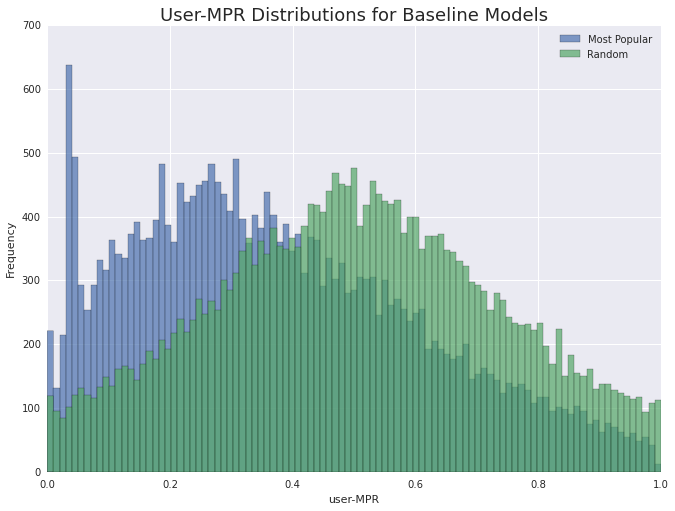

In [9]:
plt.figure(figsize=(11,8))
bins = np.linspace(0.0, 1.0, 100)
plt.hist(mostpop_umprs, bins=bins, alpha=0.7, label='Most Popular');
plt.hist(rand_umprs, bins=bins, alpha=0.7, label='Random');
plt.title('User-MPR Distributions for Baseline Models', fontsize=18);
plt.xlabel('user-MPR');
plt.ylabel('Frequency');
plt.legend(loc='upper right');

We can clearly see that recommending the most popular songs is better than recommending random songs.

One problem we will have, though, is that it is difficult to compare probability densities (ovelapping histograms gets messy). So we will make one final modification to our evaluation procedure: we will compare *cumulative* density functions. The cumulative density function of a historgram (probability density function) at a point $x$ is the number of users whose user-MPR is less than or equal to $x$. (To put it another way, it is the cumsum of the histogram).

So a *very* good model will look almost like a step function, going from zero to 1, very quickly, as x increases from 0 to 1. To put it another way: the graph of a "good" cdf will be close to the upper left corner. 

The cdf's of the above distributions are below, for comparison:

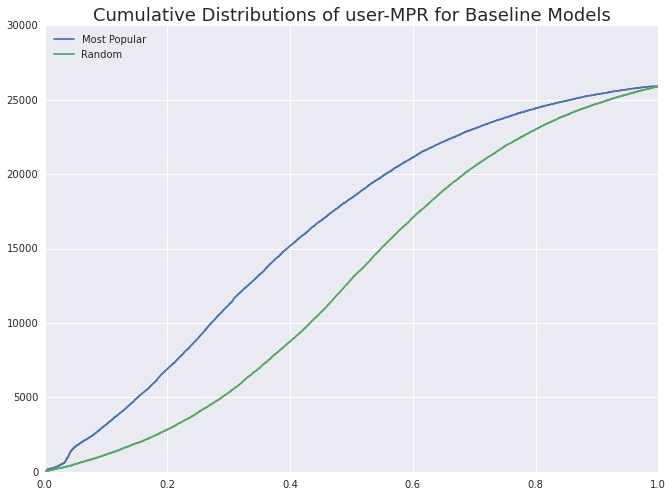

In [10]:
plt.figure(figsize=(11,8))

y = np.arange(len(mostpop_umprs))
plt.step(np.sort(mostpop_umprs), y, label='Most Popular');
plt.step(np.sort(rand_umprs), y, label='Random');
plt.legend(loc='upper left');
plt.title('Cumulative Distributions of user-MPR for Baseline Models', fontsize=18);

As expected, the most-popular model is better than the random model; the cdf is higher to the left.

## Evaluating Matrix Factorization Models

Let's train some implicit matrix factorization models. There are various hyperparameters involved in both the biased IMF model and the LogMF model. We have gridsearched for reasonable optimal hyperparameters elsewhere (that would be another post). Using these reasonable hyperparametrs, let's define and train the two models.

In [11]:
n_factors = 30
reg_param = 1.0
n_iterations = 20
seed = 42

In [12]:
bimf = ImplicitMF(observation_matrix.values,
                  num_factors=n_factors,
                  reg_param=reg_param,
                  use_biases=True)

bimf.train_model(num_iterations=n_iterations,
                 update=False,
                 seed=seed)

In [13]:
logmf = logisticmf.LogisticMF(observation_matrix.values,
                   num_factors=n_factors,
                   reg_param=reg_param,
                   iterations=30)

logmf.train_model()

Finally, let's look at the user-MPR distributions (and their associated cdf's, which will be easier to distinguish).

In [14]:
bumprs = eval_model(bimf)
lumprs = eval_model(logmf)

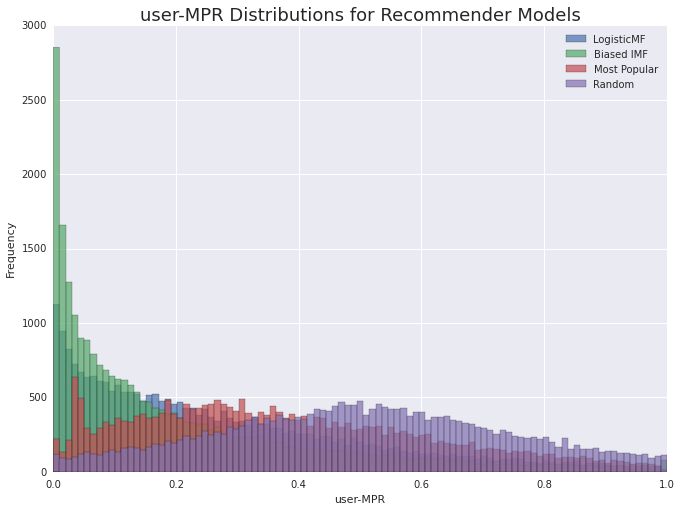

In [15]:
plt.figure(figsize=(11,8))
bins = np.linspace(0.0, 1.0, 100)
plt.hist(lumprs, bins=bins, alpha=0.7, label='LogisticMF');
plt.hist(bumprs, bins=bins, alpha=0.7, label='Biased IMF');
plt.hist(mostpop_umprs, bins=bins, alpha=0.7, label='Most Popular');
plt.hist(rand_umprs, bins=bins, alpha=0.7, label='Random');
plt.legend(loc='upper right');
plt.title("user-MPR Distributions for Recommender Models", fontsize=18);
plt.xlabel("user-MPR");
plt.ylabel("Frequency");

As expected, it is getting hard to distinguish overlapping histograms. Let's look at the corresponding cdf's.

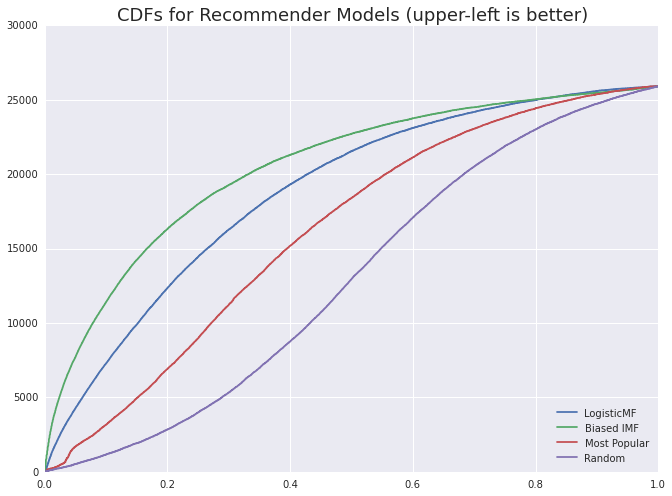

In [16]:
plt.figure(figsize=(11,8))

y = np.arange(len(lumprs))
plt.step(np.sort(lumprs), y, label='LogisticMF');
plt.step(np.sort(bumprs), y, label='Biased IMF');
plt.step(np.sort(mostpop_umprs), y, label='Most Popular');
plt.step(np.sort(rand_umprs), y, label='Random');
plt.legend(loc='lower right');
plt.title("CDFs for Recommender Models (upper-left is better)", fontsize=18);

## Conclusions

It seems that, at least when looking at Taste Profile data, the advantages of Johnson's logistic matrix factorization model vs. a vanilla implicit matrix factorization model can almost entirely be attributed to his inclusion of user and item biases.